In [1]:
import pandas as pd
import yaml
import matplotlib.pyplot as plt
from IPython.display import display, HTML

In [2]:
from modules.data import Data
from modules.search import Search
from modules.video import Video
from modules.analyze import Analyze

In [3]:
data_obj = Data()
analyze_obj = Analyze()

In [4]:
df_video_labeled = pd.read_csv("unique_id_map/videos_anonymized.csv", dtype={"channel_number": object, "video_number": object})

In [5]:
# Display duration in a readable format
df_video_labeled["video_duration"] = df_video_labeled["video_duration"].apply(analyze_obj.get_duration_in_seconds)
df_video_labeled.head()
# Get engagement metrics
df_video_labeled["likes_to_dislikes"] = df_video_labeled.apply(lambda row: analyze_obj.likes_to_dislikes(row["like_count"], row["dislike_count"]), axis=1)
df_video_labeled["dislikes_to_likes"] = df_video_labeled.apply(lambda row: analyze_obj.dislikes_to_likes(row["dislike_count"], row["like_count"]), axis=1)
df_video_labeled["engagement_score"] = df_video_labeled.apply(lambda row: analyze_obj.engagement_score(row["like_count"], row["dislike_count"], row["comment_count"], row["view_count"]), axis=1)

In [6]:
dict_variables = data_obj.load_yaml("variables.yaml")
list_category = dict_variables["category"]
list_theme = dict_variables["theme"]

In [7]:
# Get dataframes per category and label
list_df_category, list_df_theme = analyze_obj.splice_by_labels(df_video_labeled, list_category, list_theme)
list_df_category[0].head()

,video_title,video_description,view_count,like_count,dislike_count,favorite_count,comment_count,publish_time,video_duration,channel_number,video_number,category,theme,likes_to_dislikes,dislikes_to_likes,engagement_score
31,Redwood City School District To Install Vape D...,The Redwood City School District Board of Trus...,1105372,24119,1104,0,4137,2019-09-26T06:21:35Z,110,0000005,00005,Protective,News report,21846.920290,45.773042,26.561194
40,Vaping / E-Cigarette Associated Lung Injury: C...,An important update on E-Cigarette / Vaping pr...,17800,459,10,0,100,2019-11-19T20:47:35Z,304,0000012,00012,Protective,Harmful health consequences,45900.000000,21.786492,31.966292
41,"Vaping / E-Cigarette Lung Failure, Illness, Di...",Please see our most recent update to vaping as...,147156,1335,422,0,828,2019-09-19T18:12:16Z,600,0000012,00320,Protective,Harmful health consequences,3163.507109,316.104869,17.566392
43,The dangers of vaping CBD oil,"Dr. Cass Ingram, author of ""The Hemp Oil Mirac...",39012,285,421,0,144,2019-10-21T16:51:44Z,241,0000014,00014,Protective,"Harmful health consequences, News report",676.959620,1477.192982,21.788168
44,Vaping vs. Smoking,What are the effects of smoking in the lungs? ...,471,5,3,0,1,2019-08-27T00:20:31Z,146,0000015,00015,Protective,"Harmful health consequences, Comparative healt...",1666.666667,600.000000,19.108280


## Stats on views

,category,count,mean,std,median
0,Protective,132,8.415775e+05,3.478989e+06,46437.5
1,Risky,276,1.492521e+06,4.123480e+06,148152.5
2,Neutral,43,5.698636e+05,1.644923e+06,87154.0
3,Potential misinformed claims,5,1.631372e+05,9.440142e+04,203830.0


,theme,count,mean,std,median
0,Vaping tricks,102,2.972450e+06,6.252307e+06,652430.5
1,Marketing,135,3.542647e+05,7.795443e+05,91488.0
2,Harmful health consequences,150,7.757108e+05,3.277054e+06,47379.0
3,Promotion/Celebration,27,1.965180e+06,2.740716e+06,612535.0
4,Comparative health effects with smoking,91,1.045678e+06,4.185862e+06,33146.0
5,News report,47,6.001753e+05,1.638318e+06,56047.0
6,N.A.,15,3.093649e+05,7.285282e+05,51524.0


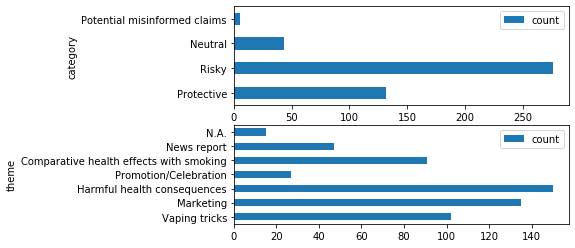

In [8]:
df_view_count_category_describe = analyze_obj.describe_df(list_df=list_df_category, label_name="category", list_label=list_category, column="view_count")
display(df_view_count_category_describe)
df_view_count_theme_describe = analyze_obj.describe_df(list_df=list_df_theme, label_name="theme", list_label=list_theme, column="view_count")
display(df_view_count_theme_describe)

fig, axes = plt.subplots(nrows=2, ncols=1)
df_view_count_category_describe.plot.barh(x="category", y="count", ax=axes[0])
df_view_count_theme_describe.plot.barh(x="theme", y="count", ax=axes[1])

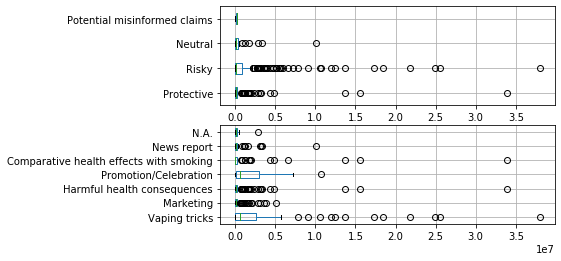

In [9]:
list_view_count_category = [list_df_category[index]["view_count"] for index, _ in enumerate(list_category)]
df_view_count_category_boxplot = pd.concat(list_view_count_category, axis=1, keys=list_category)

list_view_count_theme = [list_df_theme[index]["view_count"] for index, _ in enumerate(list_theme)]
df_view_count_theme_boxplot = pd.concat(list_view_count_theme, axis=1, keys=list_theme)

fig, axes = plt.subplots(nrows=2, ncols=1)
df_view_count_category_boxplot.boxplot(column=list_category, ax=axes[0], vert=False)
df_view_count_theme_boxplot.boxplot(column=list_theme, ax=axes[1], vert=False)

## Stats on duration

In [10]:
df_video_duration_category_describe = analyze_obj.describe_df(list_df=list_df_category, label_name="category", list_label=list_category, column="video_duration", is_count=False)
display(df_video_duration_category_describe)
df_video_duration_theme_describe = analyze_obj.describe_df(list_df=list_df_theme, label_name="theme", list_label=list_theme, column="video_duration", is_count=False)
display(df_video_duration_theme_describe)

,category,mean,std,median
0,Protective,568.469697,818.485433,283.5
1,Risky,387.420290,256.083333,325.0
2,Neutral,423.232558,407.279057,303.0
3,Potential misinformed claims,584.400000,344.558123,644.0


,theme,mean,std,median
0,Vaping tricks,307.990196,178.662384,242.0
1,Marketing,452.829630,278.239603,401.0
2,Harmful health consequences,552.100000,775.215828,290.5
3,Promotion/Celebration,375.962963,282.919325,294.0
4,Comparative health effects with smoking,481.582418,649.459691,260.0
5,News report,341.553191,361.091028,241.0
6,N.A.,465.600000,459.109511,396.0


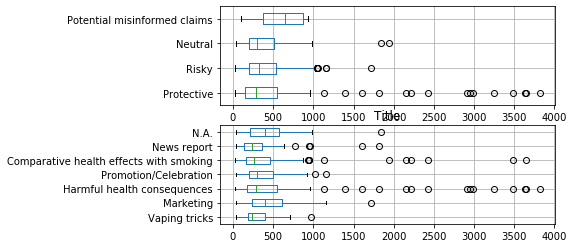

In [14]:
list_video_duration_category = [list_df_category[index]["video_duration"] for index, _ in enumerate(list_category)]
df_video_duration_category = pd.concat(list_video_duration_category, axis=1, keys=list_category)

list_video_duration_theme = [list_df_theme[index]["video_duration"] for index, _ in enumerate(list_theme)]
df_video_duration_theme = pd.concat(list_video_duration_theme, axis=1, keys=list_theme)

fig, axes = plt.subplots(nrows=2, ncols=1)
df_video_duration_category.boxplot(column=list_category, ax=axes[0], vert=False)
df_video_duration_theme.boxplot(column=list_theme, ax=axes[1], vert=False)

## Stats on engagement

Likes to dislikes
Dislikes to likes
Engagement score


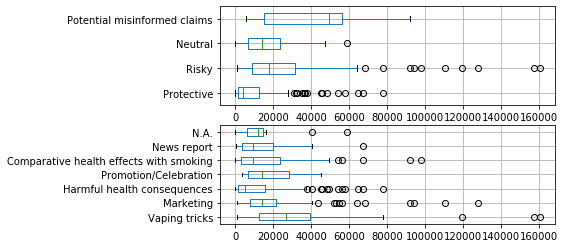

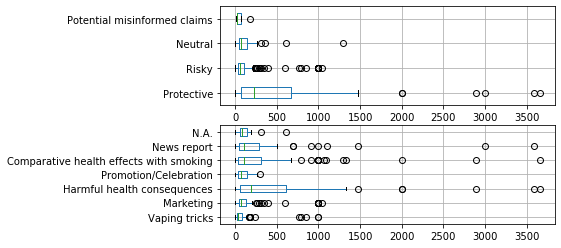

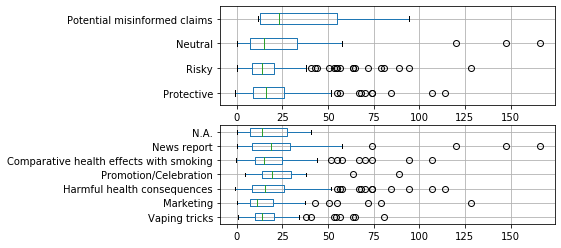

In [15]:
# Likes to dislikes
print("Likes to dislikes")
list_likes_to_dislikes_category = [list_df_category[index]["likes_to_dislikes"] for index, _ in enumerate(list_category)]
df_likes_to_dislikes_category = pd.concat(list_likes_to_dislikes_category, axis=1, keys=list_category)

list_likes_to_dislikes_theme = [list_df_theme[index]["likes_to_dislikes"] for index, _ in enumerate(list_theme)]
df_likes_to_dislikes_theme = pd.concat(list_likes_to_dislikes_theme, axis=1, keys=list_theme)

fig, axes = plt.subplots(nrows=2, ncols=1)
df_likes_to_dislikes_category.boxplot(column=list_category, ax=axes[0], vert=False)
df_likes_to_dislikes_theme.boxplot(column=list_theme, ax=axes[1], vert=False)

# Dislikes to likes
print("Dislikes to likes")

list_dislikes_to_likes_category = [list_df_category[index]["dislikes_to_likes"] for index, _ in enumerate(list_category)]
df_dislikes_to_likes_category = pd.concat(list_dislikes_to_likes_category, axis=1, keys=list_category)

list_dislikes_to_likes_theme = [list_df_theme[index]["dislikes_to_likes"] for index, _ in enumerate(list_theme)]
df_dislikes_to_likes_theme = pd.concat(list_dislikes_to_likes_theme, axis=1, keys=list_theme)

fig, axes = plt.subplots(nrows=2, ncols=1)
df_dislikes_to_likes_category.boxplot(column=list_category, ax=axes[0], vert=False)
df_dislikes_to_likes_theme.boxplot(column=list_theme, ax=axes[1], vert=False)

# Engagement score
print("Engagement score")

list_engagement_score_category = [list_df_category[index]["engagement_score"] for index, _ in enumerate(list_category)]
df_engagement_score_category = pd.concat(list_engagement_score_category, axis=1, keys=list_category)

list_engagement_score_theme = [list_df_theme[index]["engagement_score"] for index, _ in enumerate(list_theme)]
df_engagement_score_theme = pd.concat(list_engagement_score_theme, axis=1, keys=list_theme)

fig, axes = plt.subplots(nrows=2, ncols=1)
df_engagement_score_category.boxplot(column=list_category, ax=axes[0], vert=False)
df_engagement_score_theme.boxplot(column=list_theme, ax=axes[1], vert=False)